# Projet ML Souleymane Mbaye

In [2]:
import sys
sys.path.append('./')
from src import Loss,Modules
import matplotlib.pyplot as plt
%matplotlib inline  


%load_ext autoreload
%autoreload 2

## 1. Test du Module Linear avec MSELoss sur la classification de chiffres 1 vs 2

In [3]:
import numpy as np
import pickle as pkl

data = pkl.load(open('data/usps.pkl', 'rb'))
X = np.array(data['X_train'], dtype=float) # conversion de type pour une meilleure compatibilité
Y = np.array(data['Y_train'], dtype=float)

where = np.where((Y>0) & (Y<=2))[0]
X12 = X[where]
Y12 = Y[where]
Y12[Y12==1] = -1
Y12[Y12==2] = +1

In [41]:
X_test = np.array(data['X_test'], dtype=float)
Y_test = np.array(data['Y_test'], dtype=float)

where = np.where((Y_test>0) & (Y_test<=2))[0]
X12_test = X_test[where]
Y12_test = Y_test[where]

Y12_test[Y12_test==1] = -1
Y12_test[Y12_test==2] = +1

In [42]:
# Y12 = Y12.reshape(-1,1)
# Y12_test = Y12_test.reshape(-1,1)
# print(X12.shape,Y12.shape)

In [43]:
# Y12_onehot = np.zeros((len(Y12),2))
# for i in range(len(Y12)):
#   c = 0 if Y12[i] == -1 else 1
#   Y12_onehot[i,c] = 1

# Y12_test_onehot = np.zeros((len(Y12_test),2))
# for i in range(len(Y12_test)):
#   c = 0 if Y12_test[i] == -1 else 1
#   Y12_test_onehot[i,c] = 1

# Y12_onehot[:5]

In [4]:
model = Modules.Linear(256,1)
loss_fn = Loss.MSELoss()

In [5]:
def creer_batches(X,Y,batch_size=5):
  num_samples = len(Y) # nombre total d'échantillons dans Xtrain
  num_batches = num_samples // batch_size # nombre de batches
  indices = np.arange(num_samples)
  np.random.shuffle(indices) # mélanger les indices

  batches = []

  for i in range(num_batches):
    batch_indices = indices[i * batch_size:(i + 1) * batch_size]
    X_batch = X[batch_indices]
    Y_batch = Y[batch_indices]
    batches.append((X_batch,Y_batch))
  
  # dernier batch qui n'est pas plein
  # if num_samples % batch_size != 0:
  #   X_batch = X[num_batches*batch_size:]
  #   Y_batch = Y[num_batches*batch_size:]
  #   batches.append((X_batch,Y_batch))
  
  return batches

In [6]:
def train(batches,model,loss_fn,lr=1e-3,v=False):
  l_loss = []
  size = len(batches) * len(batches[0][1])
  
  for batch,(X,y) in enumerate(batches):
    # prediction
    yhat = model.forward(X)
    loss_hat = loss_fn.forward(y,yhat).sum()

    # backpropagation
    delta_loss_hat = loss_fn.backward(y,yhat)
    model.zero_grad()
    model.backward_update_gradient(delta_loss_hat)
    model.update_parameters(lr)

    l_loss.append(loss_hat)
    if v and batch % 100 == 0:
      courant = batch * len(X)
      print(f"loss: {loss_hat:>7f} [{courant:>5d}/{size:>5d}]")
  
  return np.mean(l_loss)

def test(batches,model,loss_fn,v=False):
  num_batches = len(batches)  
  size = num_batches * len(batches[0][1])
  test_loss, correct = 0,0
  
  for X,y in batches:
    yhat = model.forward(X)
    test_loss += loss_fn.forward(yhat,y).sum()
    correct += (np.where(yhat.reshape(-1) > 0, 1, -1) == y).sum()
  
  test_loss /= num_batches
  correct /= size
  if v:
    print(f"Erreur en test: \n Accuracy: {(100*correct):>0.1f}%, Moy loss: {test_loss:>8f} \n")
  
  return correct,test_loss

In [47]:
train_batches = creer_batches(X12,Y12)
test_batches = creer_batches(X12_test,Y12_test)
learning_rate = 1e-3
l_train_loss = []
l_test_loss = []
l_correct = []
l_correct_train = []
v = False

epochs = 50
for t in range(epochs):
    if v:
        print(f"Epoch {t+1}\n-------------------------------")
    
    train_loss = train(train_batches, model, loss_fn)
    correct,test_loss = test(test_batches, model, loss_fn)
    correct_train,test_loss_train = test(train_batches, model, loss_fn)

    l_train_loss.append(train_loss)
    l_test_loss.append(test_loss)
    l_correct.append(correct)
    l_correct_train.append(correct_train)

print(f"Accuracy train à la fin: \n {(100*l_correct_train[-1]):>0.1f}")
print(f"Accuracy test à la fin: \n {(100*l_correct[-1]):>0.1f}")

Accuracy train à la fin: 
 99.9
Accuracy test à la fin: 
 99.6


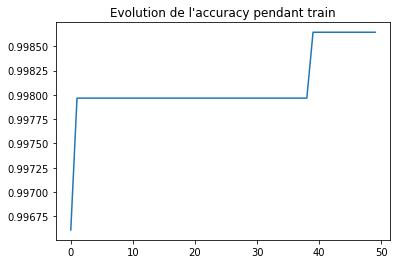

In [48]:
plt.figure()
plt.plot(np.arange(len(l_correct_train)),l_correct_train)
plt.title("Evolution de l'accuracy pendant train")
plt.show()

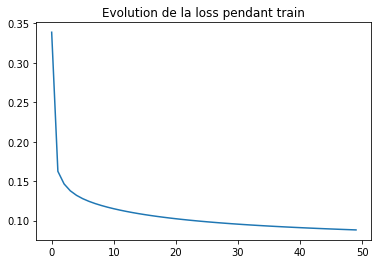

In [49]:
plt.figure()
plt.plot(np.arange(len(l_train_loss)),l_train_loss)
plt.title("Evolution de la loss pendant train")
plt.show()

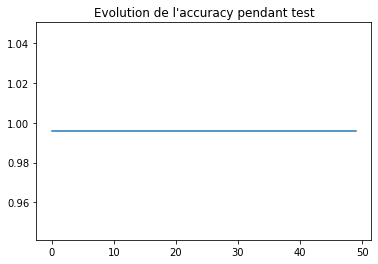

In [50]:
plt.figure()
plt.plot(np.arange(len(l_correct)),l_correct)
plt.title("Evolution de l'accuracy pendant test")
plt.show()

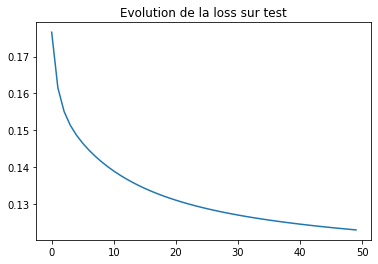

In [51]:
plt.figure()
plt.plot(np.arange(len(l_test_loss)),l_test_loss)
plt.title("Evolution de la loss sur test")
plt.show()

## Régression linéaire

In [46]:
def gen_data_lin(a, b, sig=0.1, N=100):
  X = np.sort(np.random.rand(N)) # sort optionnel, mais ça aide pour les plots
  y = a*X+b+np.random.randn(N)*sig

  return X.reshape(-1,1), y

X_lin,y_lin = gen_data_lin(a=2,b=1)
x_min, x_max = X_lin.min(),X_lin.max()

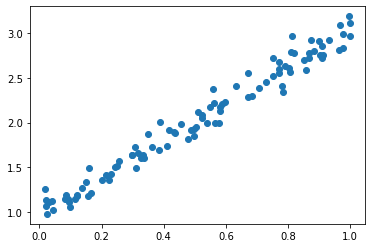

In [47]:
plt.figure()
plt.scatter(X_lin,y_lin)

In [48]:
model = Modules.Linear(1,1)
loss_fn = Loss.MSELoss()

In [111]:
train_batches = creer_batches(X_lin,y_lin)
learning_rate = 1e-3
l_train_loss = []
v = True

epochs = 10_000
for t in range(epochs):
    if v:
        print(f"Epoch {t+1} sur {epochs}  -->  {(100*((t+1)/epochs)):>0.2f}%",end='\r')
    
    train_loss = train(train_batches, model, loss_fn)

    l_train_loss.append(train_loss)


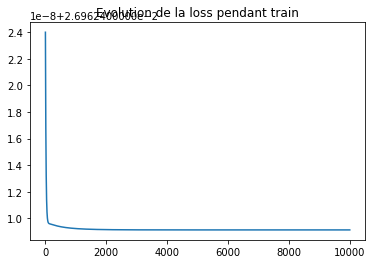

In [76]:
plt.figure()
plt.plot(np.arange(len(l_train_loss)),l_train_loss)
plt.title("Evolution de la loss pendant train")
plt.show()

In [77]:
a,b = model._parameters[0,0],model._biais[0]
y_min,y_max = a*x_min+b,a*x_max+b

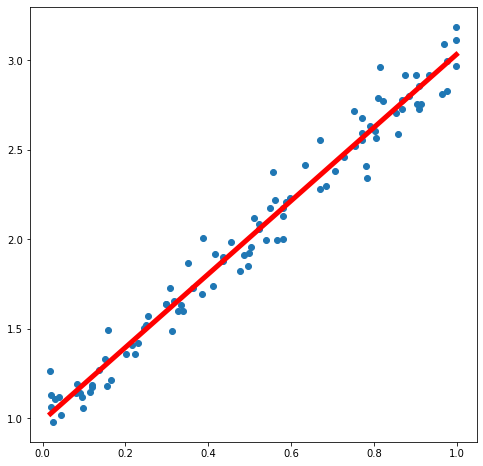

In [78]:
plt.figure(figsize=(8,8))
plt.scatter(X_lin,y_lin)
plt.plot([x_min,x_max],[y_min,y_max], c='red', linewidth=5)

## Régression linéaire poly

In [97]:
def gen_data_poly2(a, b, c, sig=0.1, N=100):
  X = np.sort(np.random.rand(N))
  y = a*X**2+b*X+c+np.random.randn(N)*sig
  
  return X, y

X_poly,y_poly = gen_data_poly2(a=10,b=-10,c=5)
x_min, x_max = X_lin.min(),X_lin.max()

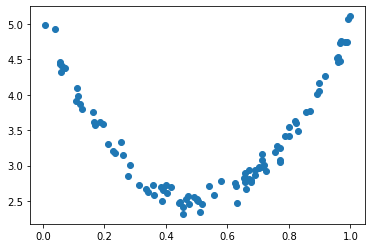

In [98]:
plt.figure()
plt.scatter(X_poly,y_poly)

In [99]:
model_poly = Modules.Linear(2,1)
loss_fn = Loss.MSELoss()

In [100]:
m_X_poly = np.array([[x**2,x] for x in X_poly])

In [106]:
train_batches = creer_batches(m_X_poly,y_poly)
learning_rate = 1e-3
l_train_loss = []
v = True

epochs = 100_000
for t in range(epochs):
    if v:
        print(f"Epoch {t+1} sur {epochs}  -->  {(100*((t+1)/epochs)):>0.2f}%",end='\r')
    
    train_loss = train(train_batches, model_poly, loss_fn)

    l_train_loss.append(train_loss)


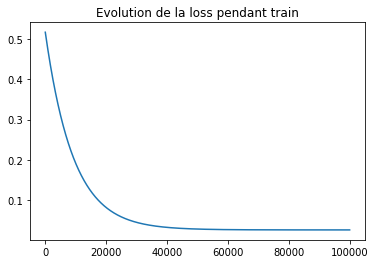

In [107]:
plt.figure()
plt.plot(np.arange(len(l_train_loss)),l_train_loss)
plt.title("Evolution de la loss pendant train")
plt.show()

In [108]:
a,b,c = model_poly._parameters[0,0], model_poly._parameters[1,0], model_poly._biais[0]
a,b,c

(9.920619119529134, -9.927239490092436, 5.000699495248936)

In [109]:
l_x = np.linspace(x_min,x_max,100)
l_x2= [x**2 for x in l_x]
l_y = [a*x2+b*x+c for x2,x in zip(l_x2,l_x)]

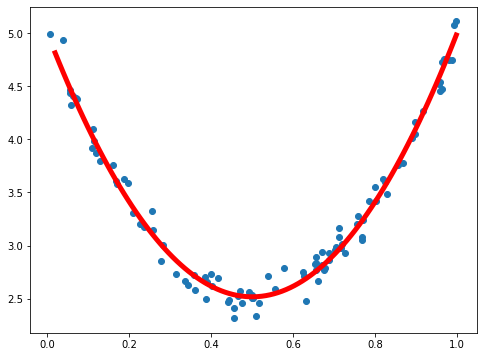

In [110]:
plt.figure(figsize=(8,6))
plt.scatter(X_poly,y_poly)
plt.plot(l_x,l_y, c='red', linewidth=5)

## Classification 2D

In [32]:
# genere_dataset_gaussian:
def genere_dataset_gaussian(pos_center, pos_sigma, neg_center, neg_sigma, nb_points,p=0.8) :
  data_neg = np.random.multivariate_normal(neg_center,neg_sigma,nb_points)
  data_pos = np.random.multivariate_normal(pos_center,pos_sigma,nb_points)
  
  dataset = np.concatenate((data_neg,data_pos))
  
  des = np.asarray([-1 for i in range(nb_points)]+[1 for i in range(nb_points)])

  L = [i for i in range(2*nb_points)]
  np.random.shuffle(L)
  n_80 = int(p * (2*nb_points))
  x_train,y_train = dataset[L[:n_80]], des[L[:n_80]]
  x_test,y_test = dataset[L[n_80:]], des[L[n_80:]]

  return x_train,y_train, x_test,y_test

# plot2DSet:
def plot2DSet(data, des):
  data_neg = data[des == -1]
  data_pos = data[des == +1]
  plt.scatter(data_neg[:,0],data_neg[:,1],marker='o',color='red')
  plt.scatter(data_pos[:,0],data_pos[:,1],marker='x',color='blue')

# plot_frontiere:
def plot_frontiere(desc_set, label_set, model, step=30):
  """ desc_set * label_set * Classifier * int -> NoneType
      Remarque: le 4e argument est optionnel et donne la "résolution" du tracé: plus il est important
      et plus le tracé de la frontière sera précis.        
      Cette fonction affiche la frontière de décision associée au classifieur
  """
  mmax=desc_set.max(0)
  mmin=desc_set.min(0)
  x1grid,x2grid=np.meshgrid(np.linspace(mmin[0],mmax[0],step),np.linspace(mmin[1],mmax[1],step))
  grid=np.hstack((x1grid.reshape(x1grid.size,1),x2grid.reshape(x2grid.size,1)))
  
  # calcul de la prediction pour chaque point de la grille
  yhat = model.forward(grid)
  res = np.where(yhat.reshape(-1) > 0, 1, -1)
  res=res.reshape(x1grid.shape)
  # tracer des frontieres
  # colors[0] est la couleur des -1 et colors[1] est la couleur des +1
  plt.contourf(x1grid,x2grid,res,colors=["darksalmon","skyblue"],levels=[-1000,0,1000])

Taille du dataset généré train : (400, 2) exemples
Taille du dataset généré test : (100, 2) exemples


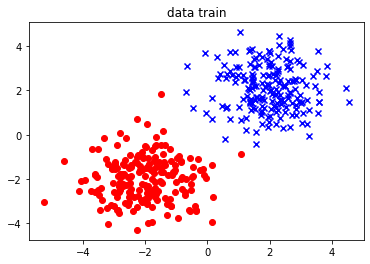

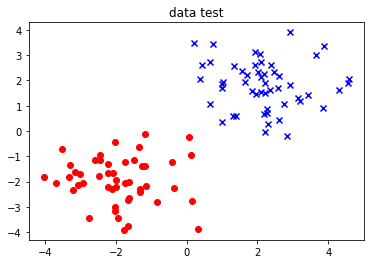

In [21]:
np.random.seed(42)   # on prend 42 comme graine

# On génère un dataset de 500 exemples en dimension 2:
x_train,y_train, x_test,y_test = genere_dataset_gaussian(np.array([2,2]),np.array([[1,0],[0,1]]),np.array([-2,-2]),np.array([[1,0],[0,1]]),250,p=0.8)

print("Taille du dataset généré train :", np.shape(x_train), "exemples")
print("Taille du dataset généré test :", np.shape(x_test), "exemples")


# Affichage des exemples générés train:
plot2DSet(x_train,y_train)
plt.title("data train")
plt.show()
# Affichage des exemples générés test:
plot2DSet(x_test,y_test)
plt.title("data test")
plt.show()

In [22]:
model_g = Modules.Linear(2,1)
loss_fn = Loss.MSELoss()

In [26]:
train_batches = creer_batches(x_train,y_train)
test_batches = creer_batches(x_test,y_test)
learning_rate = 1e-3
l_train_loss = []
l_test_loss = []
l_correct = []
l_correct_train = []
v = True

epochs = 50
for t in range(epochs):
    if v:
        print(f"Epoch {t+1} sur {epochs}  -->  {(100*((t+1)/epochs)):>0.2f}%",end='\r')
    
    train_loss = train(train_batches, model_g, loss_fn)
    correct,test_loss = test(test_batches, model_g, loss_fn)
    correct_train,test_loss_train = test(train_batches, model_g, loss_fn)

    l_train_loss.append(train_loss)
    l_test_loss.append(test_loss)
    l_correct.append(correct)
    l_correct_train.append(correct_train)

print(f"\nAccuracy train à la fin: \n {(100*l_correct_train[-1]):>0.1f}")
print(f"Accuracy test à la fin: \n {(100*l_correct[-1]):>0.1f}")

Epoch 50 sur 50  -->  100.00%
Accuracy train à la fin: 
 99.5
Accuracy test à la fin: 
 100.0


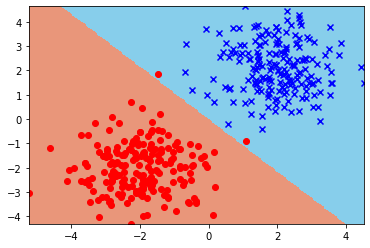

In [33]:
# Affichage de la frontière de séparation des classes
plot_frontiere(x_train,y_train,model_g,step=150)
plot2DSet(x_train,y_train)

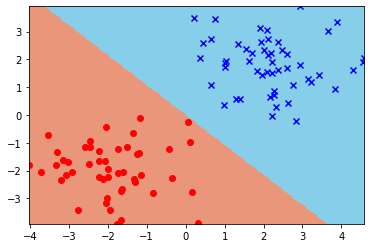

In [34]:
# Affichage de la frontière de séparation des classes
plot_frontiere(x_test,y_test,model_g,step=150)
plot2DSet(x_test,y_test)

## Avec un XOR

In [35]:
def create_XOR(n,sig):
  data_neg1 = np.random.multivariate_normal(np.array([0,0]),np.array([[sig,0],[0,sig]]),n)
  data_neg2 = np.random.multivariate_normal(np.array([1,1]),np.array([[sig,0],[0,sig]]),n)
  data_neg  = np.concatenate((data_neg1,data_neg2))
  
  data_pos1 = np.random.multivariate_normal(np.array([1,0]),np.array([[sig,0],[0,sig]]),n)
  data_pos2 = np.random.multivariate_normal(np.array([0,1]),np.array([[sig,0],[0,sig]]),n)
  data_pos  = np.concatenate((data_pos1,data_pos2))
  
  dataset = np.concatenate((data_neg,data_pos))
  
  des = np.asarray([-1 for i in range(2*n)]+[1 for i in range(2*n)])

  return dataset, des

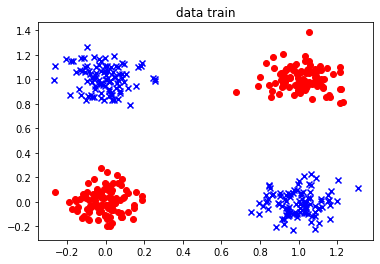

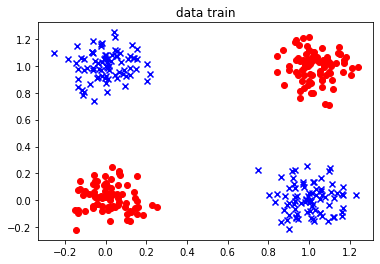

In [39]:
np.random.seed(42)   # on prend 42 comme graine

# Génération d'un dataset avec 80 points:
data_xor, label_xor = create_XOR(100,0.01)
data_xor_test, label_xor_test = create_XOR(80,0.01)

plot2DSet(data_xor, label_xor)
plt.title('data train')
plt.show()

plot2DSet(data_xor_test, label_xor_test)
plt.title('data train')
plt.show()

In [40]:
m_data_xor = np.array([[x1,x2,x1**2,x1*x2,x2**2,1] for [x1,x2] in data_xor])
m_data_xor_test = np.array([[x1,x2,x1**2,x1*x2,x2**2,1] for [x1,x2] in data_xor_test])

m_data_xor.shape

(400, 6)

In [41]:
model_xor = Modules.Linear(6,1)
loss_fn = Loss.MSELoss()

In [48]:
train_batches = creer_batches(m_data_xor,label_xor)
test_batches = creer_batches(m_data_xor_test,label_xor_test)
learning_rate = 1e-3
l_train_loss = []
l_test_loss = []
l_correct = []
l_correct_train = []
v = True

epochs = 5000
for t in range(epochs):
    if v:
        print(f"Epoch {t+1} sur {epochs}  -->  {(100*((t+1)/epochs)):>0.2f}%",end='\r')
    
    train_loss = train(train_batches, model_xor, loss_fn)
    correct,test_loss = test(test_batches, model_xor, loss_fn)
    correct_train,test_loss_train = test(train_batches, model_xor, loss_fn)

    l_train_loss.append(train_loss)
    l_test_loss.append(test_loss)
    l_correct.append(correct)
    l_correct_train.append(correct_train)

print(f"\nAccuracy train à la fin: \n {(100*l_correct_train[-1]):>0.1f}")
print(f"Accuracy test à la fin: \n {(100*l_correct[-1]):>0.1f}")

Epoch 5000 sur 5000  -->  100.00%
Accuracy train à la fin: 
 100.0
Accuracy test à la fin: 
 100.0


In [45]:
def plot_frontiere_xor(desc_set, label_set, model, step=30):
  """ desc_set * label_set * Classifier * int -> NoneType
      Remarque: le 4e argument est optionnel et donne la "résolution" du tracé: plus il est important
      et plus le tracé de la frontière sera précis.        
      Cette fonction affiche la frontière de décision associée au classifieur
  """
  mmax=desc_set.max(0)
  mmin=desc_set.min(0)
  x1grid,x2grid=np.meshgrid(np.linspace(mmin[0],mmax[0],step),np.linspace(mmin[1],mmax[1],step))
  grid=np.hstack((x1grid.reshape(x1grid.size,1),x2grid.reshape(x2grid.size,1)))
  
  # calcul de la prediction pour chaque point de la grille
  yhat = model.forward(np.array([[x1,x2,x1**2,x1*x2,x2**2,1] for [x1,x2] in grid]))
  res = np.where(yhat.reshape(-1) > 0, 1, -1)
  res=res.reshape(x1grid.shape)
  # tracer des frontieres
  # colors[0] est la couleur des -1 et colors[1] est la couleur des +1
  plt.contourf(x1grid,x2grid,res,colors=["darksalmon","skyblue"],levels=[-1000,0,1000])

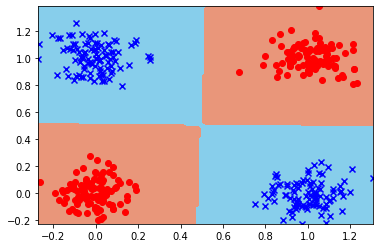

In [49]:
# Affichage de la frontière de séparation des classes
plot_frontiere_xor(m_data_xor,label_xor,model_xor,step=150)
plot2DSet(data_xor,label_xor)

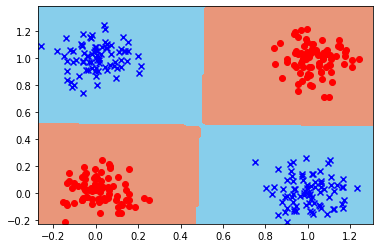

In [51]:
# Affichage de la frontière de séparation des classes
plot_frontiere_xor(m_data_xor,label_xor,model_xor,step=150)
plot2DSet(data_xor_test,label_xor_test)